auc: 0.7645098039215686
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       100
           1       0.63      0.67      0.65        51

    accuracy                           0.75       151
   macro avg       0.73      0.73      0.73       151
weighted avg       0.76      0.75      0.76       151



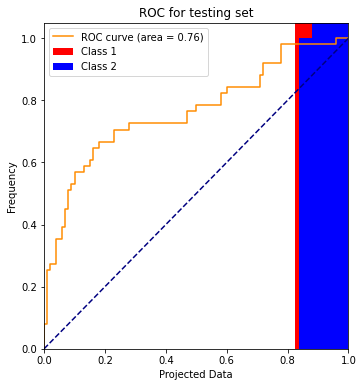

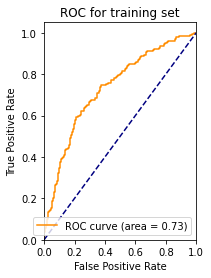

auc: 0.7317683002868187
              precision    recall  f1-score   support

           0       0.87      0.69      0.77       729
           1       0.39      0.67      0.50       220

    accuracy                           0.68       949
   macro avg       0.63      0.68      0.63       949
weighted avg       0.76      0.68      0.71       949



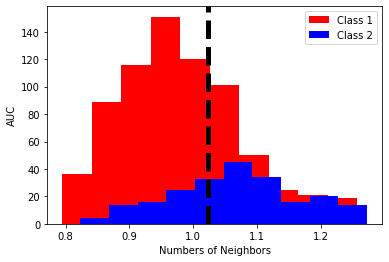

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import time

class LDA_2class:
    def __init__(self):
        self.mean = None
        self.std = None
        self.w = None
        self.larger = None

    def fit(self,train_X,train_y):
        train_X0 = train_X[train_y==0]
        train_X1 = train_X[train_y==1]
        n1 = train_X0.shape[0]
        n2 = train_X1.shape[0]
        m1 = train_X0.mean()
        m2 = train_X1.mean()
        S_B = np.outer(m2-m1,m2-m1)
        # S_W = np.zeros(S_B.shape)
        # for i in range(train_X0.shape[0]):
        #     S_W = np.add(np.outer(train_X0.iloc[i,:]-m1,train_X0.iloc[i,:]-m1),S_W)
        # for i in range(train_X1.shape[0]):
        #     S_W = np.add(np.outer(train_X1.iloc[i,:]-m2,train_X1.iloc[i,:]-m2),S_W)
        S_W = ((train_X0-m1).T).dot(train_X0-m1) + ((train_X1-m2).T).dot(train_X1-m2)
        lamb, W = np.linalg.eigh(np.linalg.pinv(S_W).dot(S_B))
        eiglist = [(lamb[i], W[:, i]) for i in range(len(lamb))]
        eiglist = sorted(eiglist, key = lambda x : x[0], reverse = True)
        self.w = eiglist[0][1]
        self.w0 = (np.dot(self.w, m1) + np.dot(self.w, m2))/2
        self.larger = np.dot(self.w, m2) >= self.w0
        
    def score(self,test_X):
        if self.larger:
            return test_X.dot(self.w)
        else:
            return 1-test_X.dot(self.w)
        
    def predict(self,test_X):
        if self.larger:
            return (test_X.dot(self.w)) >= self.w0
        else:
            return (test_X.dot(self.w)) < self.w0
  
#%% Read the data
# train = pd.read_csv("..\\bankruptcy data\\adj_imp_train.csv")
# test = pd.read_csv("..\\bankruptcy data\\adj_imp_test.csv")
# train = pd.read_csv("..\\bankruptcy data\\training_knn.csv",index_col=0)
# test = pd.read_csv("..\\bankruptcy data\\testing_knn.csv",index_col=0)
# train = pd.read_csv("..\\bankruptcy data\\smote_train.csv")
# test = pd.read_csv("..\\bankruptcy data\\adj_imp_test.csv")

train = pd.read_csv("../data/pca_train.csv")
test = pd.read_csv("../data/pca_test.csv")

train_X = train.iloc[:,:-1]/10
train_y = train.iloc[:,-1]
test_X = test.iloc[:,:-1]/10
test_y = test.iloc[:,-1]

tic = time.time()
model = LDA_2class()
model.fit(train_X,train_y)
toc = time.time()


#%% Model report test set
predict = model.predict(test_X)
score = model.score(test_X)

auc = roc_auc_score(test_y, score)

fpr, tpr, _ = roc_curve(test_y, score)


plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for testing set')
plt.legend(loc="lower right")

print("auc:", auc)

print(classification_report(test_y, predict))


#%% visualization
    
plt.hist(score[:100],color="red",label="Class 1")
plt.hist(score[100:],color="blue", label="Class 2")
plt.axvline(1-model.w0,linewidth=5,color="black",linestyle='--')
plt.xlabel('Projected Data')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#%% Model report train set
predict = model.predict(train_X)
score = model.score(train_X)

auc = roc_auc_score(train_y, score)

fpr, tpr, _ = roc_curve(train_y, score)

plt.subplot(122)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for training set')
plt.legend(loc="lower right")
plt.show()

print("auc:", auc)

print(classification_report(train_y, predict))

#%% visualization
    
plt.hist(score[:728],color="red",label="Class 1")
plt.hist(score[728:],color="blue",label="Class 2")
plt.axvline(1-model.w0,linewidth=5,color="black",linestyle='--')
plt.xlabel('Numbers of Neighbors')
plt.ylabel('AUC')
plt.legend()
plt.show()